In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../data/application_data.csv', index_col='SK_ID_CURR')
data = data[data.columns[:40]]

In [3]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,1,MONDAY,11,0,0,0,0,0,0,School
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,2,MONDAY,9,0,0,0,0,0,0,Government
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,2,THURSDAY,11,0,0,0,0,1,1,Religion


In [4]:
data.shape

(307511, 40)

### target count

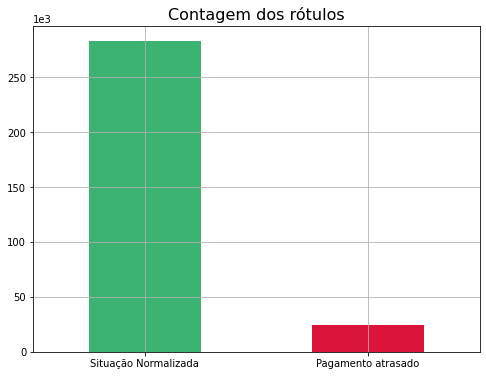

In [5]:
data['TARGET'].map({0:'Situação Normalizada', 1:'Pagamento atrasado'}).value_counts().plot.bar(rot=0, figsize=(8, 6), color=['mediumseagreen', 'crimson'])
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.title('Contagem dos rótulos', fontsize=16)
plt.grid()

### types of features

In [6]:
categorical_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
                       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE']

non_binary_categorical = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                          'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

time_columns = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']

numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
                     'CNT_FAM_MEMBERS', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
                     'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE',
                     'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

### missing data

In [7]:
missing_values_columns = data.count()[data.count() < data.shape[0]].index.to_list()
data.count()[data.count() < data.shape[0]]

AMT_ANNUITY        307499
AMT_GOODS_PRICE    307233
NAME_TYPE_SUITE    306219
OWN_CAR_AGE        104582
OCCUPATION_TYPE    211120
CNT_FAM_MEMBERS    307509
dtype: int64

In [8]:
data = data[(pd.notnull(data['AMT_ANNUITY'])) & (pd.notnull(data['AMT_GOODS_PRICE'])) & 
            (pd.notnull(data['NAME_TYPE_SUITE'])) & (pd.notnull(data['CNT_FAM_MEMBERS']))]

data.loc[pd.isnull(data['OWN_CAR_AGE']), 'OWN_CAR_AGE'] = 0

data.loc[pd.isnull(data['OCCUPATION_TYPE']), 'OCCUPATION_TYPE'] = 'None'

data.loc[:, 'CODE_GENDER'] = data.loc[:, 'CODE_GENDER'].map({'M':0, 'XNA':0.5, 'F':1})

### one hot encoding for non binary categorical features

In [9]:
data = pd.concat([data, pd.get_dummies(data[non_binary_categorical])], axis=1)
data.drop(non_binary_categorical, axis=1, inplace=True)

In [10]:
data['FLAG_EMP_PHONE'].dtype

dtype('int64')

### applying label encoder

In [11]:
mapping = {}
for column in categorical_columns:
    
    if column in ['CODE_GENDER'] + non_binary_categorical or data[column].dtype == int:
        continue
    
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    category2label = dict(zip(le.classes_, le.transform(le.classes_)))
    label2category = dict(zip(le.transform(le.classes_), le.classes_))
    mapping[column] = (category2label, label2category)

with open('../data/mapping_columns.json', 'w') as f:
    print(mapping, file=f)

### time transformation (cos)

In [12]:
data['WEEKDAY_APPR_PROCESS_START'] = data['WEEKDAY_APPR_PROCESS_START'].map({'MONDAY':0, 'TUESDAY':1, 
                                                                             'WEDNESDAY':2, 'THURSDAY':3,
                                                                             'FRIDAY':4, 'SATURDAY':5, 'SUNDAY':6})

data['WEEKDAY_APPR_PROCESS_START'] = np.cos(2*np.pi*data['WEEKDAY_APPR_PROCESS_START'] / 7)

data['HOUR_APPR_PROCESS_START'] = np.cos(2*np.pi*data['HOUR_APPR_PROCESS_START'] / 24)

### log transformation for currency features

In [13]:
data[['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
      'AMT_INCOME_TOTAL']] = data[['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
                                   'AMT_INCOME_TOTAL']].applymap(lambda x: np.log(x))

### split train/test

In [14]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

### feature scaling

In [15]:
features2scale = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
                  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'OWN_CAR_AGE']

scaler = MinMaxScaler()

# fit_transform on train and only transform on test
X_train.loc[:, features2scale] = scaler.fit_transform(X_train.loc[:, features2scale])
X_test.loc[:, features2scale] = scaler.transform(X_test.loc[:, features2scale])

/home/caio/Documents/am1/am1/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/caio/Documents/am1/am1/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [16]:
X_train.to_csv('../data/X_train.csv')
X_test.to_csv('../data/X_test.csv')